# 1.2 - Marginal Gaussianization

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(root))

%load_ext autoreload
%autoreload 2

## Import Packages

In [2]:
from typing import Union

import numpy as np

from sklearn.datasets import make_moons
from scipy import stats
# Packages
import numpy as np
import pytorch_lightning as pl


# Plot
import matplotlib.pyplot as plt
import corner

import wandb
pl.seed_everything(1234)

%load_ext autoreload
%autoreload 2

Global seed set to 1234


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Logging

In [17]:
# TODO

## Data

In [3]:
ntrain = 100_000
ntest = 10_000
noise = 0.1
random_state = 123
train_data = make_moons(n_samples=ntrain, noise=noise, random_state=random_state)[0]
test_data = make_moons(n_samples=ntest, noise=noise, random_state=random_state*10)[0]

### Plot Data

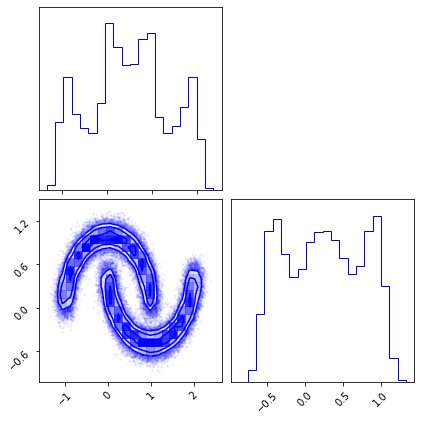

In [4]:
fig = plt.figure(figsize=(7, 7))

corner.corner(train_data, color="blue", fig=fig)

plt.show()

## Flow Transformation

In [5]:
class Bijector:
    
    def forward(self, X):
        raise NotImplemented
        
    def inverse(self, X):
        raise NotImplemented
    
    def gradient(self, X):
        raise NotImplemented
    

### Marginal Gaussianization

#### Marginal Uniformization

In [21]:
class MarginalHistogramUniformization:
    def __init__(self, X: np.ndarray, bins: Union[int,str]="auto", alpha: float=1e-10, bound_ext: float=0.1):
        
        estimators = []
        
        
        for iX in X.T:
            diff = iX.max() - iX.min()
            lower_bound = iX.min() - bound_ext * diff
            upper_bound = iX.max() + bound_ext * diff

            # create histogram 
            hist = np.histogram(iX, bins=bins, range=(lower_bound, upper_bound))

            # create histogram object
            i_estimator = stats.rv_histogram(hist)

            # add some regularization
            i_estimator._hpdf += alpha
            
            estimators.append(i_estimator)
            
        self.estimators = estimators
        
    def forward(self, X):
        
        Z = np.zeros_like(X)
        for idim, iX in enumerate(X.T):
            Z[:, idim] = self.estimators[idim].cdf(iX)
        
        return Z
    
    def inverse(self, Z):
        
        X = np.zeros_like(Z)
        
        for idim, iZ in enumerate(Z.T):
            
            X[:, idim] = self.estimators[idim].ppf(iZ)
        
        return X
    
    def gradient(self, X):
        
        X_grad = np.zeros_like(X)
        
        for idim, iX in enumerate(X.T):
            X_grad[:, idim] = self.estimators[idim].pdf(iX)
        
        return X_grad

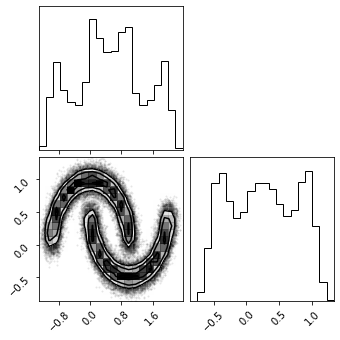

In [22]:
fig = corner.corner(train_data)

In [6]:
from rbig._src.uniform import MarginalHistogramUniformization

In [7]:
marg_hist_bijector = MarginalHistogramUniformization(X=train_data)

In [8]:
X_u = marg_hist_bijector.forward(train_data)

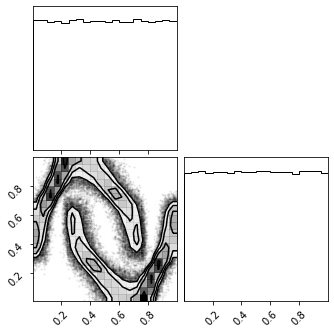

In [9]:
fig = corner.corner(X_u)

#### Inverse Transforms

In [10]:
X_approx = marg_hist_bijector.inverse(X_u)

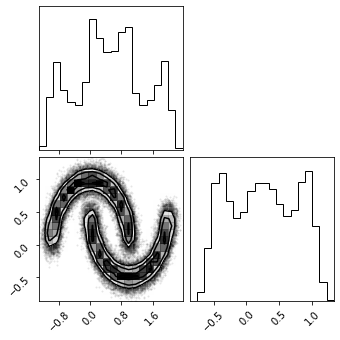

In [11]:
fig = corner.corner(X_approx)

## Inverse Gaussian CDF

In [12]:
from rbig._src.invcdf import InverseGaussCDF

invcdf = InverseGaussCDF(eps=1e-5)

### Forward

In [13]:
X_g = invcdf.forward(X_u)

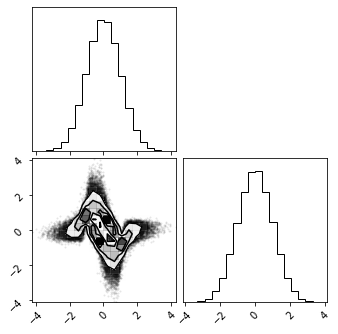

In [14]:
fig = corner.corner(X_g)

### Inverse

In [15]:
X_u_approx = invcdf.inverse(X_g)

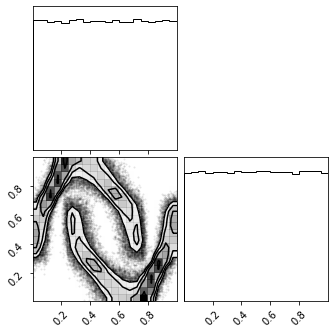

In [16]:
fig = corner.corner(X_u_approx)

### Jacobian

In [17]:
X_g_grad = invcdf.gradient(X_u)

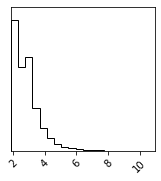

In [18]:
fig = corner.corner(X_g_grad)

## Composing Transfirmations

In [19]:
from rbig._src.base import CompositeBijector

bijectors = [marg_hist_bijector, invcdf]

marg_gauss_bijector = CompositeBijector(bijectors)

In [20]:
X_g = marg_gauss_bijector.forward(train_data)

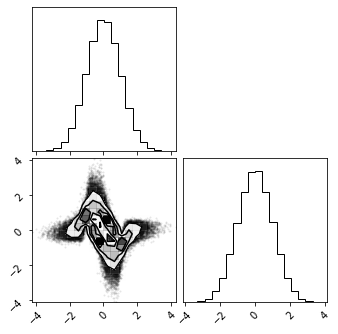

In [21]:
fig = corner.corner(X_g)

In [22]:
X_approx = marg_gauss_bijector.inverse(X_g)

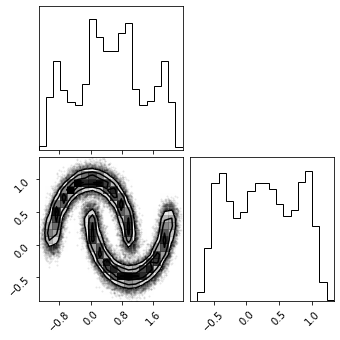

In [23]:
fig = corner.corner(X_approx)

### Jacobian

In [24]:
X_ldj = marg_gauss_bijector.gradient(train_data)

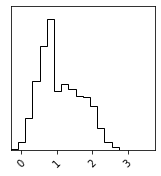

In [25]:
fig = corner.corner(X_ldj)

### Density Estimation

In [27]:
# 1) latent prob
Xg = marg_gauss_bijector.forward(train_data)

# latent probability
base_dist = stats.norm(loc=0, scale=1)

pz = base_dist.pdf(Xg).sum(axis=1)

# 2) prob
X_detjacobian = marg_gauss_bijector.gradient(train_data)



# total prob
p_x = pz * X_detjacobian

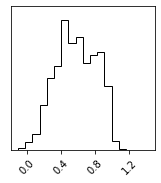

In [28]:
fig = corner.corner(p_x)

## Sampling

In [29]:
# 1) samples from latent probability
base_dist = stats.norm(loc=0, scale=1)
pz_samples = np.vstack([base_dist.rvs(size=10_000, random_state=123), base_dist.rvs(size=10_000, random_state=42)]).T

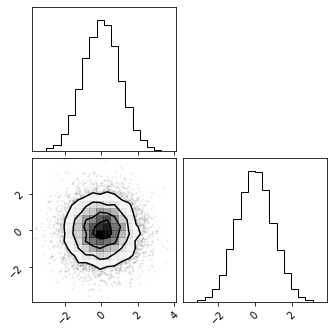

In [30]:
fig = corner.corner(pz_samples)

In [31]:
X_samples = marg_gauss_bijector.inverse(pz_samples)

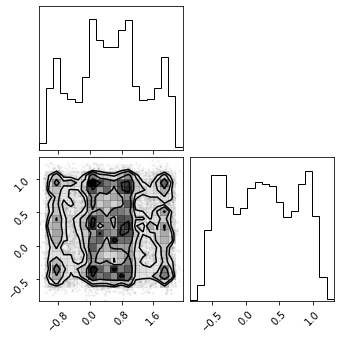

In [32]:
fig = corner.corner(X_samples)